In [1]:
import matplotlib.pyplot as plt
import re
import pandas as pd
import seaborn as sns
import pandas.api.types as ptypes
import numpy as np
import optuna
import joblib
import plotly
from step import *
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn import ensemble
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, KFold

In [2]:
df_alg = pd.read_csv("../../data/joao-pessoa-aluguel.csv")
df1 = pd.read_csv("../../data/joao_pessoa.csv").drop(columns=["andar"])
df2 = pd.read_csv("../../data/joao_pessoa1.csv") \
    .drop(columns=["z_lat", "z_lon", "bairro_completo",
                   "comercio", "bairro", "zona"]) \
    .transform(lambda x: x.apply(lambda y: float(y)) if ptypes.is_bool_dtype(x) else x)

In [3]:
df3 = pd \
    .read_csv('../../data/aluguel_social_jp.csv', delimiter=';') \
    .query('`ANO DO PAGAMENTO` == 2023') \
    .dropna(subset=['BAIRRO']) \
    .rename(columns={'BAIRRO': 'bairro'}) \
    .assign(bairro=lambda x: x.bairro.str.strip().str.title()) \
    .replace(
        {
            r'M[AaNnGg]([a-zA-Z])*\sI': 'Mangabeira I',
            r'M[AaNnGg]([a-zA-Z])*\sII': 'Mangabeira II',
            r'M[AaNnGg]([a-zA-Z])*\sIII': 'Mangabeira III',
            r'M[AaNnGg]([a-zA-Z])*\sIV': 'Mangabeira IV',
            r'M[AaNnGg]([a-zA-Z])*\sVii': 'Mangabeira IV',
            'Mangabeira Iv': 'Mangabeira IV',
            'Mangabeira Iii': 'Mangabeira III',
            'Mangabeira Ii': 'Mangabeira II',
            'Mangabeira Vi': 'Mangabeira VI',
            'Mangabeira Vii': 'Mangabeira VII',
            'Mangabeira Viii': 'Mangabeira VIII',
            'Mangabeira, Viii': 'Mangabeira VIII',
            'Mangabeira 8': 'Mangabeira VIII',
            r'M[AaNnGg]([a-zA-Z])*': 'Mangabeira',
            r'Varad([a-zA-Z]).*': 'Varadouro',
            'Jd Veneza': 'Jardim Veneza',
            'Jd Cidade Universitaria': 'Jardim Cidade Universitaria',
            'Mangabeira \( Aratu\)': 'Mangabeira',
            'Monsenhor Mangabeira': 'Mangabeira',
            'Mangabeira 1': 'Mangabeira',
            'Mangabeira \(Aratu\)': 'Mangabeira',
            'Bairro Dos Estados': 'Estados',
            'Mangabeira 6': 'Mangabeira VI',
            'Cristo': 'Cristo Redentor',
        },
        regex=True
    ) \
    .replace(
        {
            'Monsenhor Mangabeira': 'Mangabeira',
            'Baixo Roger': 'Roger',
            'Funcionarios 2': 'Funcionarios II a IV',
            'Cristo Redentor Redentor': 'Cristo Redentor',
            'Baixo Roger ( Vila Lula\nLucena)': 'Roger',
            'Collinas Do Sul': 'Colinas do Sul',
            'Cidade Verde - Bairro Das Industrias': 'Bairro das Industrias',
            'Cristo Redentor/Vale Das Palmeiras': 'Cristo Redentor',
            'Biarro Das Industria': 'Bairro das Industrias',
            'Altiplano 2': 'Altiplano',
            'Dos Ipes': 'Bairro Dos Ipes',
            'Aeroclube/Bessa': 'Aeroclube',
            'Bairro Sao Jose': 'Sao Jose',
            'B. Industrias': 'Bairro das Industrias',
            'Industrias': 'Bairro das Industrias',
            'B Das Industrias': 'Bairro das Industrias',
            'Funcionarios Ii': 'Funcionarios II a IV',
            'Bela Vista/Cristo Redentor': 'Cristo Redentor',
            'Sao Jose/ Barreira': 'Sao Jose',
            'B. Dos Estados': 'Estados',
            '13 De Mangabeira': 'Mangabeira',
            'Cristro Redentor': 'Cristo Redentor',
            'Funcionario Iii': 'Funcionarios II a IV',
            'Gervasio Mangabeira': 'Mangabeira',
            'Ipes': 'Bairro Dos Ipes',
            'B. Das Industrias': 'Bairro das Industrias',
            'Joao Paulo Ii': 'Joao Paulo II',
            'Padreze': 'Padre Ze',
            'Valentina I': 'Valentina',
            'B. Dos Novais': 'Bairro dos novais',
            'Novais': 'Bairro dos novais',
            'Treze De Mangabeira': 'Mangabeira',
            'Estados': 'Bairro dos estados'
        }
    ) \
    .reset_index(drop=True)
df3 = df3.replace({'Estados': 'bairro dos estados'})

df3 = df3.assign(bairro=lambda x: x.bairro.str.lower().str.replace(' ', '_')) \
    .groupby(['bairro'], as_index=False).size() \
    .rename(columns={'size': 'qnt_beneficio'})

In [4]:
def extract_location(address):
    pattern_joao_pessoa = re.compile(r'(.+),\s*João Pessoa$')
    match_joao_pessoa = pattern_joao_pessoa.search(address)

    if match_joao_pessoa:
        return match_joao_pessoa.group(1).strip()

    pattern_general = re.compile(r',\s*([^,]+)$')
    match_general = pattern_general.search(address)

    if match_general:
        return match_general.group(1).strip()

    return None

def clear_addr(x):
    pattern = re.compile(r'[-,\s]*(.*?)\s*,?\s*João Pessoa - PB')
    extracted_parts = [pattern.search(address).group(1) if pattern.search(address) else None for address in x]

    return [re.sub(r'^.* - ', '', address) for address in extracted_parts]

df1 = df1 \
    .assign(
        bairro=lambda x: clear_addr(x.endereco),
        error=lambda x: list(map(lambda y: ('Rua' in y) or (y == ''), x.bairro.tolist())),
    ) \
    .query('error == False') \
    .reset_index(drop=True) \
    .drop(columns=['error']) \
    .replace(
        {
            'Valentina Figueiredo': 'Valentina de Figueiredo',
            'Jardim Treze de Maio': 'Jardim 13 de Maio'
        }
    )

df2 = df2.assign(bairro=lambda x: [extract_location(address) for address in x.endereco])

df_alg = df_alg \
    .assign(bairro=lambda x: clear_addr(x.endereco)) \
    .replace({
        'Altiplano Cabo Branco': 'Altiplano',
        'ipes': 'Bairro dos Ipes',
        'Estados': 'Bairro dos estados',
        'Jardim Treze de Maio': 'Jardim 13 de Maio',
        'Ipês': 'Bairro dos Ipes'
    })

df_alg = df_alg \
    .assign(
        bairro=lambda x: x.bairro.str.normalize('NFKD') \
            .str.encode('ascii', errors='ignore') \
            .str.decode('utf-8') \
            .str.lower() \
            .str.replace(' ', '_')
    ) \
    .rename(
        columns={
            'area': 'area_aluguel',
            'valor': 'valor_aluguel',
            # 'vaga': 'vaga_aluguel',
            # 'quarto': 'quarto_aluguel',
            # 'banheiro': 'banheiro_aluguel'
            }
        ) \
    .groupby(['bairro'], as_index=False) \
    [['area_aluguel', 'valor_aluguel']] \
    .median()

In [5]:
df = pd.concat([df1, df2]) \
    .drop_duplicates('id') \
    .reset_index(drop=True) \
    .drop(columns=['id', 'url']) \
    .query('bairro != "Monsenhor Magno"') \
    .replace(
        {
            'Altiplano Cabo Branco': 'Altiplano',
            'Estados': 'Bairro dos estados',
            'Ipês': 'Bairro dos ipes',
            'Industrias': 'Bairro das Industrias',
            'Cidade dos Funcionarios II': 'Funcionários II a IV',
            'Cidade dos Colibris': 'Colibris',
            'Conjunto Pedro Gondim': 'Pedro gondim',
            'José Américo de Almeida': 'jose americo'
        }
    )

df = df \
    .assign(bairro=lambda x: x.bairro.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(' ', '_').str.lower()) \
    .merge(df_alg, on='bairro', how='left') \
    .merge(df3, on='bairro', how='left') \
    .reset_index(drop=True)

## Cleaning

In [6]:
def remove_outliers_iqr(data, feature, threshold=1.5):
    df = data.copy()
    q1, q3 = np.percentile(df[feature],  [1, 99])
    iqr = q3 - q1
    upper_bound = q3 + threshold * iqr

    removed_rows = df[df[feature] > upper_bound].index

    if(feature == 'valor'):
        df = df.drop(removed_rows, axis=0)
        return df.query("valor >= 40000").reset_index(drop=True)
    else:
        return df.drop(removed_rows, axis=0).reset_index(drop=True)


In [7]:
df = df.fillna(
    value={
        "academia": 0, "area_servico": 0,
        "elevador": 0, "espaco_gourmet": 0,
        "piscina": 0, "playground": 0,
        "portaria_24_horas": 0, "quadra_de_esporte": 0,
        "salao_de_festa": 0, "sauna": 0,
        "spa": 0, "varanda_gourmet": 0}
    ) \
    .replace(["flat", "terrenos_lotes_condominio"],
             ["flats", "terrenos_lotes_e_condominios"]) \
    .assign(
        latitude_norm=lambda x: (x.latitude - x.latitude.mean()) / x.latitude.std(),
        longitude_norm=lambda x: (x.longitude - x.longitude.mean()) / x.longitude.std(),
    ) \
    .query("-2 < latitude_norm < 2") \
    .query("-2 < longitude_norm < 2") \
    .query("area < 150000 and area >= 20 and valor < 12_000_000 and valor > 40000") \
    .query("tipo not in ['casas_de_vila', 'sobrados', 'coberturas', 'casas_comerciais']") \
    .reset_index(drop=True) \
    .drop(columns=["longitude_norm", "latitude_norm"])

In [8]:
df = remove_outliers_iqr(
    df.assign(
        valor_area = df.valor * df.area
        ),
    "valor_area"
    ) \
    .drop(columns=["valor_area"])

## Train and test dataset

In [9]:
df['valor_cut'] = pd.cut(df['valor'],
    bins=[0.,2e5, 4e5, 6e5, 8e5, np.inf],
    labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df.valor_cut):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]
train_df = train_df.drop(columns=['valor_cut']).reset_index(drop=True)
test_df = test_df.drop(columns=['valor_cut']).reset_index(drop=True)

df.drop(columns=["valor_cut"]).to_csv("../../data/cleaned/jp_limpo.csv", index=False)
train_df.to_csv("../../data/cleaned/train.csv", index=False)
test_df.to_csv("../../data/cleaned/test.csv", index=False)

train_df = train_df.drop(columns=['qnt_beneficio'])
test_df = test_df.drop(columns=['qnt_beneficio'])

## Missing values

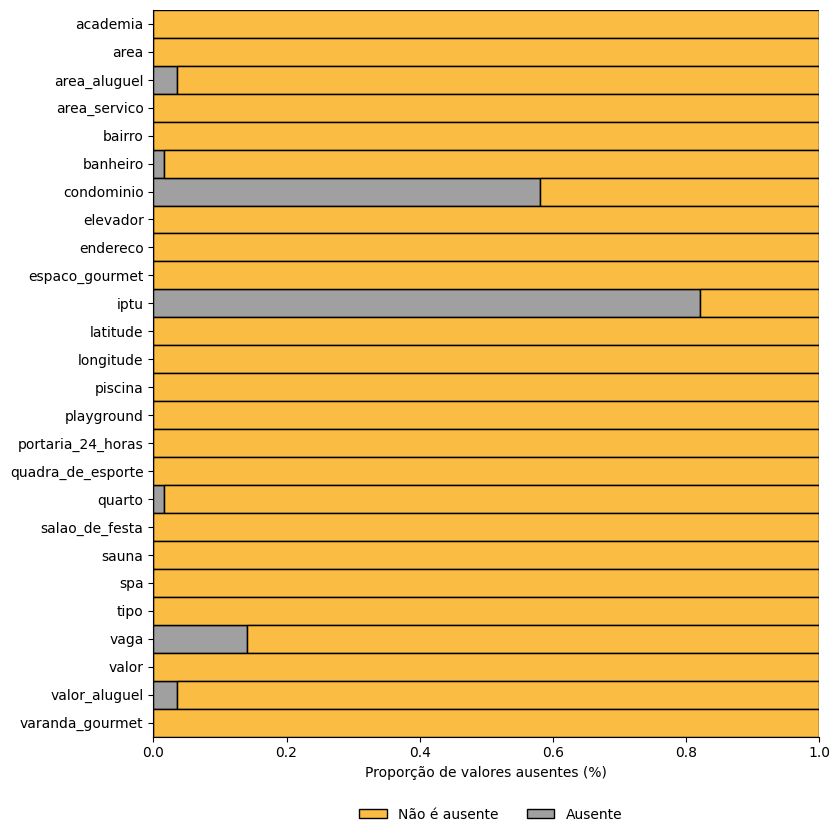

In [10]:
g_missing = sns.displot(
    data=train_df.isnull() \
        .melt(value_name="Valores ausentes") \
        .replace([False, True], ["Não é ausente", "Ausente"]) \
        .groupby(["variable", "Valores ausentes"]).size() \
        .reset_index(name="count") \
        .assign(
            proportion=lambda x: x.groupby("variable")["count"].transform(lambda y: y / y.sum())
        ),
    y="variable",
    hue="Valores ausentes",
    weights="proportion",
    multiple="fill",
    height=8,
    aspect=1.1,
    palette={"Não é ausente": "#f9a602", "Ausente": "gray"}
    )

sns.move_legend(obj=g_missing, loc="upper center",
                bbox_to_anchor=(.5, -.0001), ncol=2, title="")
g_missing.set(xlabel="Proporção de valores ausentes (%)", ylabel="")

### Some functions

In [11]:
def display_scores(scores, confidence=0.95):

    print("Scores:", scores)
    print("Média:", scores.mean())
    print("Desvio Padrão:", scores.std())

In [12]:
def plot_error(scores):
    ax, fig = plt.subplots(figsize=(20, 20))
    lineplot = sns.lineplot(y=scores, x=list(range(1, 11)))
    plt.title('Raiz do erro quadrático médio', fontdict={'fontsize': 18})
    plt.xlabel('CV', fontdict={'fontsize': 14})
    plt.ylabel('RMSE', fontdict={'fontsize': 14})
    lineplot.set_xticklabels(lineplot.get_xticklabels(), fontdict={'fontsize': 13})
    lineplot.set_yticklabels(lineplot.get_yticklabels(), fontdict={'fontsize': 13})
    plt.show()

In [13]:
def plot_predict(model):
    plt.figure(figsize=(20, 20))
    scatter = sns.scatterplot(y=np.exp(model.predict(test_df.drop('valor', axis=1))), x=np.exp(test_df.valor) - 1)
    plt.title('Predições VS Valores Reais', fontdict={'fontsize': 18})
    plt.xlabel('Valores Reais', fontdict={'fontsize': 13})
    plt.ylabel('Predições', fontdict={'fontsize': 13})
    plt.show()

In [14]:
gbr_native = ensemble.GradientBoostingRegressor()
lgbm_native = LGBMRegressor()
rf_native = ensemble.RandomForestRegressor()
xgboost_native = XGBRegressor()

## Modeling 

In [15]:
train_df = train_df.assign(valor=lambda x: np.log1p(x.valor))
test_df = test_df.assign(valor=lambda x: np.log1p(x.valor))

In [16]:
drop_cols_fit = ['endereco', 'bairro', 'iptu', 'condominio']

pipe_jp = Pipeline(
    [("imputer", Imputer()),
     ("new_feature", BedAreaBedToi()),
     ("ordinal_encoder", OrdEncoder()),
     ("onehot_encoder", OneEncoder()),
     ("log_transform", LogTransform()),
     ("scaling", Scale())
    ])
pipe_jp.fit(train_df.drop(columns=drop_cols_fit))

Pipeline(steps=[('imputer', Imputer()), ('new_feature', BedAreaBedToi()),
                ('ordinal_encoder', OrdEncoder()),
                ('onehot_encoder', OneEncoder()),
                ('log_transform', LogTransform()), ('scaling', Scale())])

In [17]:
train_df_novo = pipe_jp.transform(train_df.drop(columns=drop_cols_fit))
test_df_novo = pipe_jp.transform(test_df.drop(columns=drop_cols_fit))

In [18]:
# s = setup(train_df_novo, target='valor')
# best = compare_models()

In [19]:
test_df_clone = test_df.copy()

## Optim

### LGBM

In [20]:
def objective_lgbm(trial):
    num_leaves = trial.suggest_int('num_leaves', 100, 2000)
    max_depth = trial.suggest_int('max_depth', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, .01)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)

    model = LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)


In [21]:
# study_lgbm = optuna.create_study(direction="minimize")
# study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=-1, show_progress_bar=True)

In [20]:
best_params_lgbm = {
    'num_leaves': 247,
    'max_depth': 299,
    'learning_rate': 0.009035568789398086,
    'n_estimators': 1798}

In [23]:
lgbm = LGBMRegressor(
    **best_params_lgbm,
    random_state=42,
    n_jobs=1)

In [23]:
lgbm.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 25424, number of used features: 28
[LightGBM] [Info] Start training from score 13.051175


LGBMRegressor(learning_rate=0.009035568789398086, max_depth=299,
              n_estimators=1798, n_jobs=1, num_leaves=247, random_state=42)

In [24]:
lgbm.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

0.8717132732488375

In [25]:
preds_lgbm = lgbm.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_lgbm'] = preds_lgbm

In [58]:
print(np.expm1(mean_absolute_error(test_df_clone.valor, preds_lgbm)))
print(mean_absolute_percentage_error(test_df_clone.valor, preds_lgbm))
print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds_lgbm)))

0.19238978783348568
0.01346860273584294
0.2849393488711858


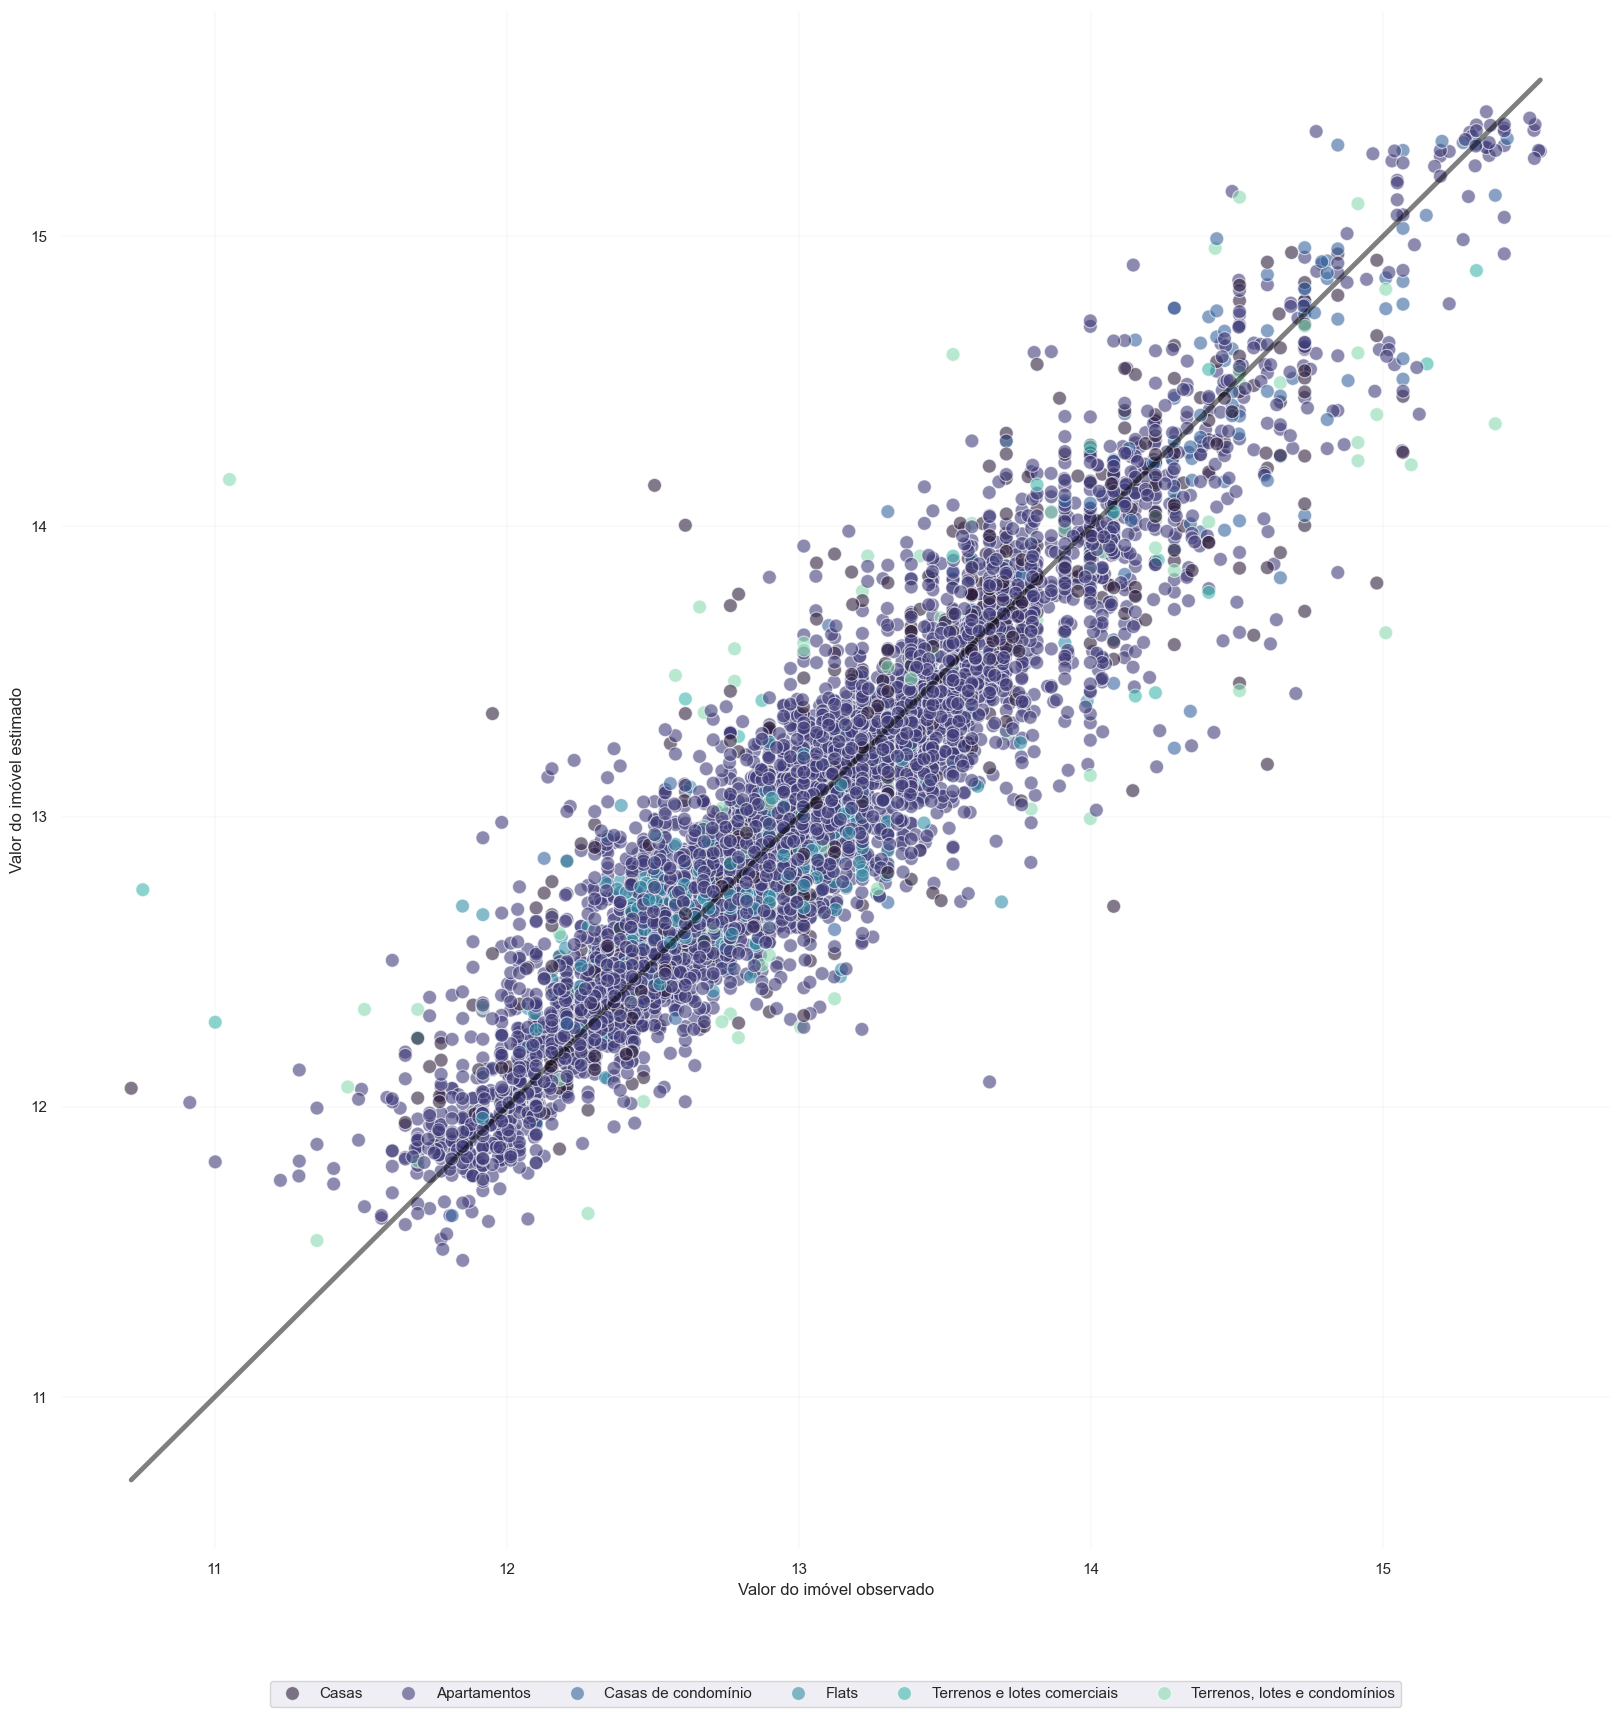

In [50]:
fig = plt.Figure(figsize=(20, 20))

plot = sns.scatterplot(
    # data=test_df_clone\
    # .assign(
    #     nivel=lambda x: (x.academia + x.espaco_gourmet + x.quadra_de_esporte +
    #      x.sauna + x.varanda_gourmet + x.playground).astype(object)
    # ),
    data=test_df_clone,
    x='valor',
    y='preds_lgbm',
    s=100,
    # style='nivel',
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(test_df_clone['valor'].min(), test_df_clone['preds_lgbm'].min())
max_val = max(test_df_clone['valor'].max(), test_df_clone['preds_lgbm'].max())
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

sns.set_theme(rc={'figure.figsize': (20, 20)})
plot.set_xlabel('Valor do imóvel observado')
plot.set_ylabel('Valor do imóvel estimado')

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=7)
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
# plt.savefig("../../tcc_escrita/includes/lgbm_plot_predict.svg", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#joblib.dump(study_lgbm, 'study_pkl/study_lgbm.pkl')

### Random Forest

In [20]:
forest = ensemble.RandomForestRegressor(
    n_estimators=650,
    random_state=42,
    max_depth=22,
    max_features="sqrt",
    n_jobs=1)

In [39]:
forest.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)

RandomForestRegressor(max_depth=22, max_features='sqrt', n_estimators=650,
                      n_jobs=1, random_state=42)

In [116]:
forest.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

0.867879292250632

In [117]:
preds = forest.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds'] = preds

In [118]:
print(np.expm1(mean_absolute_error(test_df_clone.valor, preds)))
print(mean_absolute_percentage_error(test_df_clone.valor, preds))
print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds)))

0.19698163817598713
0.013739975648249261
0.28972668442292576


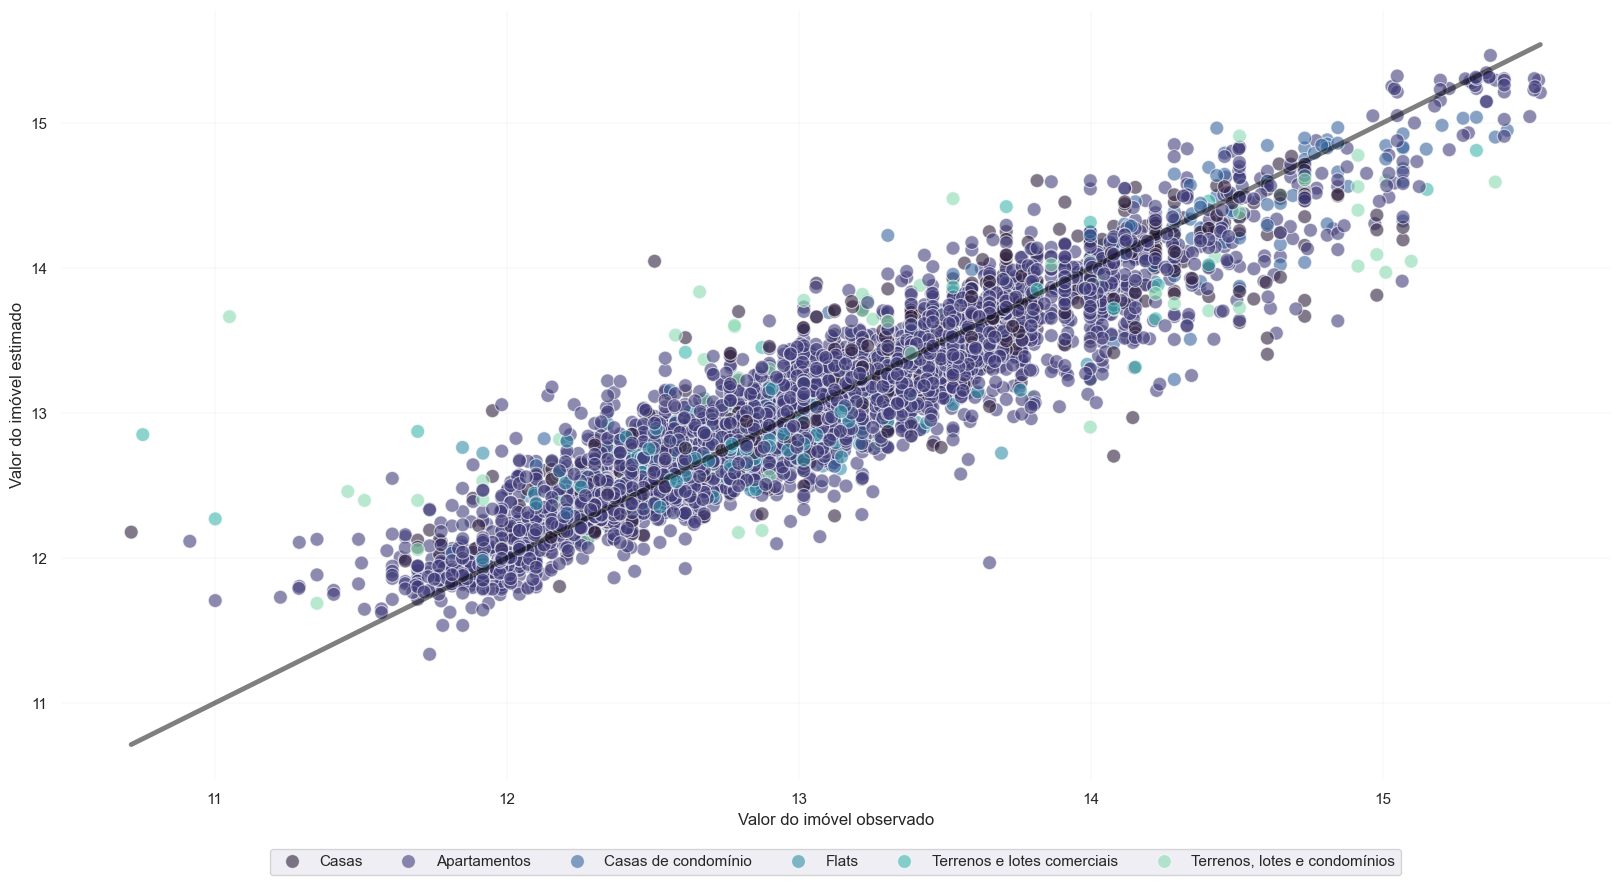

In [134]:
fig = plt.Figure(figsize=(20, 20))

plot = sns.scatterplot(
    data=test_df_clone,
    x='valor',
    y='preds',
    s=100,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(test_df_clone['valor'].min(), test_df_clone['preds'].min())
max_val = max(test_df_clone['valor'].max(), test_df_clone['preds'].max())
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

sns.set_theme(rc={'figure.figsize': (20, 10)})
plot.set_xlabel('Valor do imóvel observado')
plot.set_ylabel('Valor do imóvel estimado')

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=7)
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("../../tcc_escrita/includes/rf_plot_predict.svg", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
def objective_rf(trial):
    params = dict(
        n_estimators=trial.suggest_int(name='n_estimators', low=1, high=2000),
        max_depth=trial.suggest_int(name='max_depth', low=20, high=1000),
        max_features='sqrt',
        random_state=42
    )

    model = ensemble.RandomForestRegressor(
        **params,
        n_jobs=3
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop("valor", axis=1),
        y=train_df_novo.valor,
        scoring="neg_mean_squared_error",
        n_jobs=3,
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)

In [29]:
joblib.dump(study, 'study_pkl/study_rf.pkl')

['study_pkl/study_rf.pkl']

In [ ]:
# study = optuna.create_study(direction="minimize")
# study.optimize(objective_rf, n_trials=100, show_progress_bar=True, n_jobs=-1)

[I 2024-11-30 11:00:16,664] A new study created in memory with name: no-name-05288283-5494-405d-bb67-46501cb9634e


  0%|          | 0/100 [00:00<?, ?it/s]

[W 2024-11-30 11:01:30,446] Trial 0 failed with parameters: {'n_estimators': 1299, 'max_depth': 343} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_92500/2797378472.py", line 15, in objective_rf
    cv_scores = np.expm1(np.sqrt(-cross_val_score(
  File "/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 719, in cross_val_score
    cv_results = cross_validate(
  File "/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site

KeyboardInterrupt: 

In [37]:
plot = optuna.visualization.plot_param_importances(study)
plot.update_layout(
    title="",
    xaxis_title="Importância dos Hiperparâmetros",
    yaxis_title="Hiperparâmetros"
)

## Gradient boosting

In [24]:
def objective_gbr(trial):
    learning_rate = trial.suggest_float(name='learning_rate', low=0.1e-4, high=0.1)
    n_estimators = trial.suggest_int(name='n_estimators', low=50, high=1500)
    max_depth = trial.suggest_int(name='max_depth', low=3, high=500)
    max_features = 'sqrt'


    model = ensemble.GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        max_features=max_features,
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)


In [21]:
# study_gdr = optuna.create_study(direction='minimize')
# study_gdr.optimize(objective_gbr, n_trials=100, show_progress_bar=True)

In [21]:
best_params_gdt = {
    'learning_rate': 0.08730488291054857,
    'n_estimators': 1500,
    'max_depth': 6
    }

gdt = ensemble.GradientBoostingRegressor(
    **best_params_gdt,
    random_state=42,
    max_features="sqrt")

In [112]:
gdt.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)
gdt.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

0.8698259842658491

In [113]:
preds_gdt = gdt.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_gdt'] = preds_gdt

In [114]:
print(np.expm1(mean_absolute_error(test_df_clone.valor, preds_gdt)))
print(mean_absolute_percentage_error(test_df_clone.valor, preds_gdt))
print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds_gdt)))

0.1972628214715287
0.013776609896730248
0.287302514253656


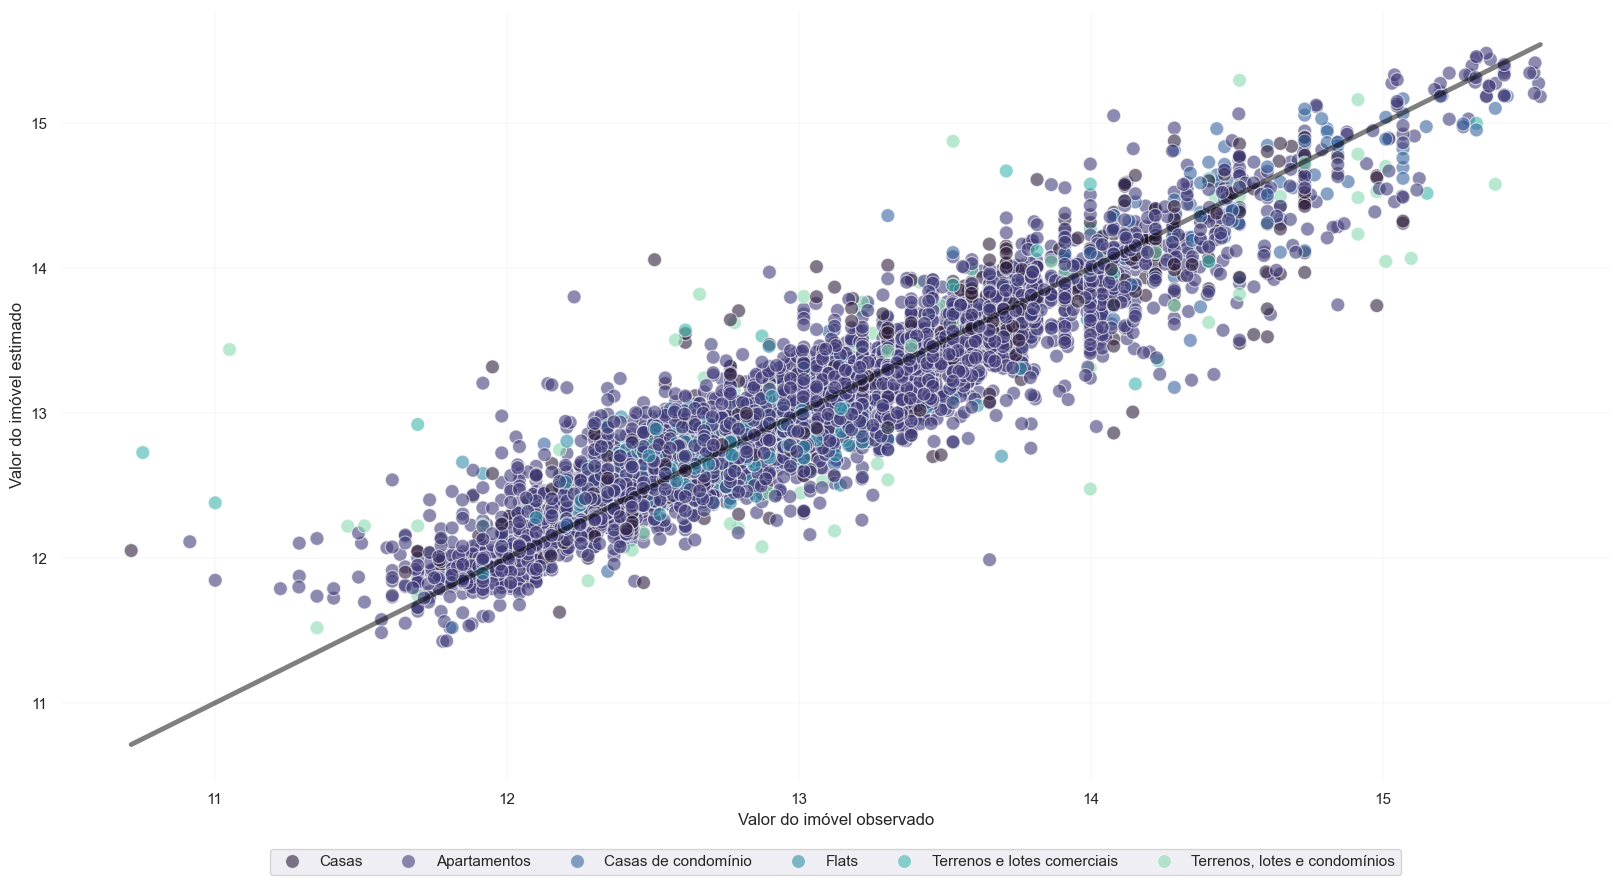

In [151]:
fig = plt.Figure(figsize=(20, 20))

plot = sns.scatterplot(
    data=test_df_clone,
    x='valor',
    y='preds_gdt',
    s=100,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(test_df_clone['valor'].min(), test_df_clone['preds_gdt'].min())
max_val = max(test_df_clone['valor'].max(), test_df_clone['preds_gdt'].max())
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

sns.set_theme(rc={'figure.figsize': (20, 10)})
plot.set_xlabel('Valor do imóvel observado')
plot.set_ylabel('Valor do imóvel estimado')

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=7)
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("../../tcc_escrita/includes/gdt_plot_predict.svg", dpi=600, bbox_inches='tight')
plt.show()

In [34]:
joblib.dump(study_gdr, "study_pkl/study_gdt.pkl")

['study_pkl/study_gdt.pkl']

### XGBoost

In [ ]:
def objective_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-7, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'random_state': 42
    }

    model = XGBRegressor(**params)
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)


In [22]:
best_params_xgb = {
    'n_estimators': 788,
    'learning_rate': 0.07119699155402735,
    'max_depth': 8}

xgb = XGBRegressor(
    **best_params_xgb,
    random_state=42)

In [97]:
xgb.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)
xgb.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

0.8703891884346289

In [98]:
preds_xgb = xgb.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_xgb'] = preds_xgb

In [110]:
print(np.expm1(mean_absolute_error(test_df_clone.valor, preds_xgb)))
print(mean_absolute_percentage_error(test_df_clone.valor, preds_xgb))
print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds_xgb)))

0.19143784628195912
0.013403951136016732
0.28659864902611343


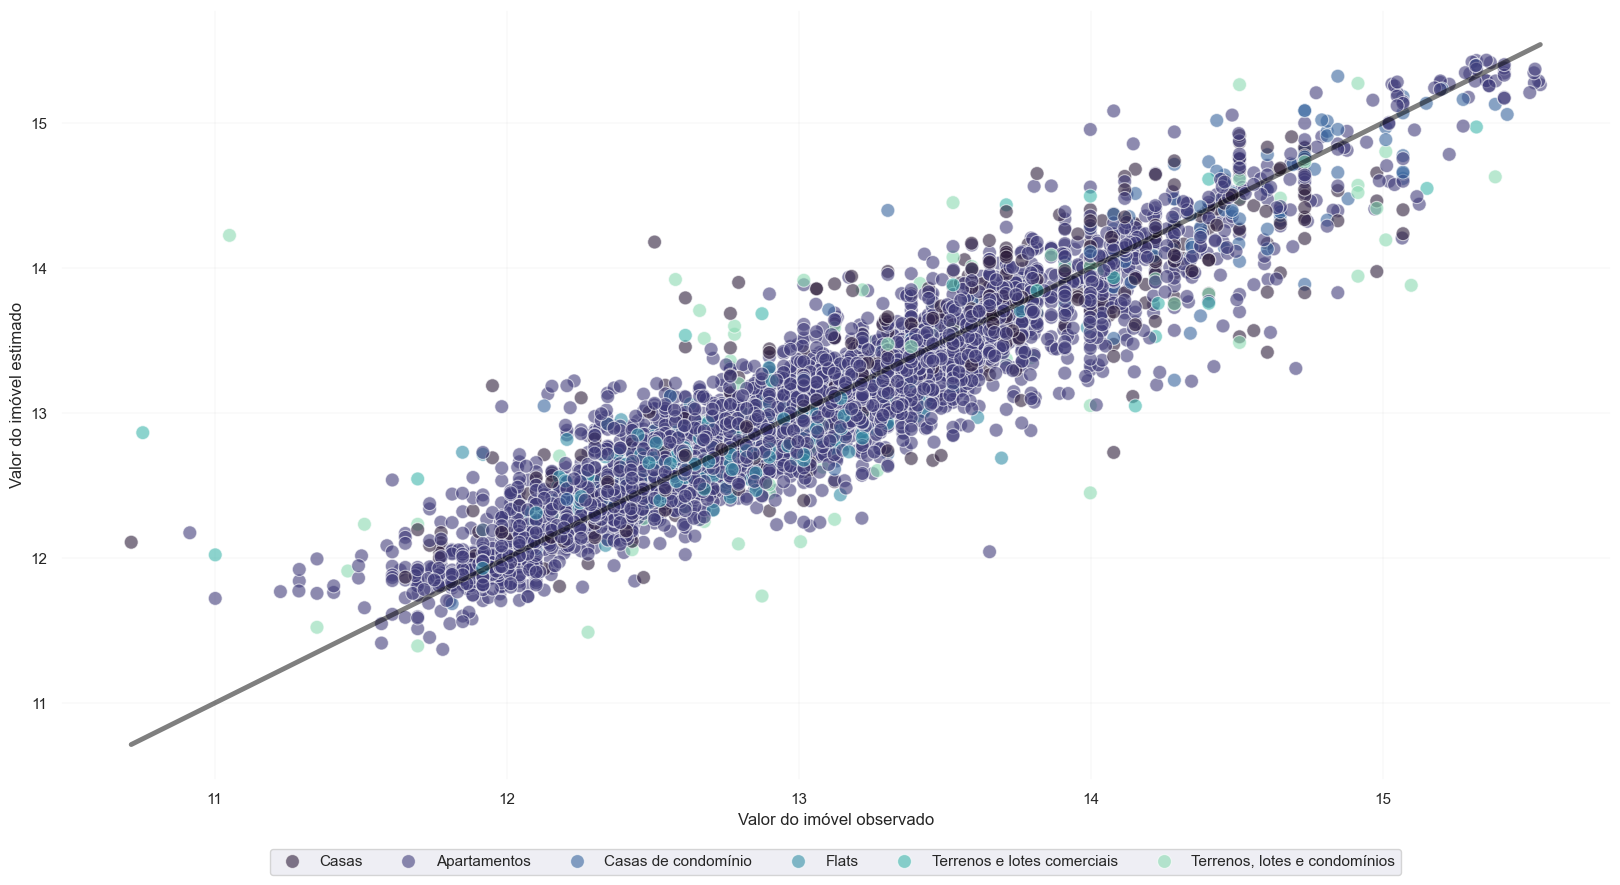

In [161]:
fig = plt.Figure(figsize=(20, 20))

plot = sns.scatterplot(
    data=test_df_clone,
    x='valor',
    y='preds_xgb',
    s=100,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(test_df_clone['valor'].min(), test_df_clone['preds_xgb'].min())
max_val = max(test_df_clone['valor'].max(), test_df_clone['preds_xgb'].max())
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

sns.set_theme(rc={'figure.figsize': (20, 10)})
plot.set_xlabel('Valor do imóvel observado')
plot.set_ylabel('Valor do imóvel estimado')

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=7)
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("../../tcc_escrita/includes/xgb_plot_predict.svg", dpi=600, bbox_inches='tight')
plt.show()

In [20]:
# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgboost, n_trials=100, n_jobs=-1)

In [ ]:
# joblib.dump(study_xgb, 'study_pkl/study_xgb.pkl')

['study_pkl/study_xgb.pkl']

## Stacking

In [23]:
estimators = [
    ('xgb', XGBRegressor(**best_params_xgb, random_state=42)),
    ('rf', ensemble.RandomForestRegressor(
        n_estimators=650,
        random_state=42,
        max_depth=22,
        max_features="sqrt",
        n_jobs=1
    )),
    ('lgbm', LGBMRegressor(**best_params_lgbm, random_state=42, n_jobs=1)),
    ('gdt', ensemble.GradientBoostingRegressor(
        **best_params_gdt,
        random_state=42,
        max_features="sqrt"
    ))
]

stacking = ensemble.StackingRegressor(
    estimators=estimators,
    final_estimator=ensemble.RandomForestRegressor(
        n_estimators=650,
        random_state=42,
        max_depth=22,
        max_features="sqrt",
        n_jobs=1
    ),
    verbose=2,
    n_jobs=3
)

In [24]:
stacking.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)
# stacking.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 25424, number of used features: 28
[LightGBM] [Info] Start training from score 13.051175


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1555
[LightGBM] [Info] Number of data points in the train set: 20339, number of used features: 28
[LightGBM] [Info] Start training from score 13.054060
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 20339, number of used features: 28
[LightGBM] [Info] Start training from score 13.052644
[LightGBM] [Info] Total 

[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    9.1s remaining:    6.1s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:   33.1s remaining:   22.1s


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 20340, number of used features: 28
[LightGBM] [Info] Start training from score 13.047820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 20339, number of used features: 28
[LightGBM] [Info] Start training from score 13.051755


[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:   43.3s remaining:   28.8s
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:   56.4s remaining:   37.6s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   52.4s finished
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  1.2min finished


StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                               LGBMRegressor(learning_rate=0.009035568789398086,
                                             max_depth=299, n_estimators=1798,
                                             n_jobs=1, num_leaves=247,
                                             random_state=42)),
                              ('gdt',
                               GradientBoostingRegressor(learning_rate=0.08730488291054857,
                                                         max_depth=6,
                                                         max_features='sqrt',
                                                         n_estimators=1500,
                                                         random_state=42))],
                  final_estimator=RandomForestRegressor(max_depth=22,
                                                        max_features='sqrt',
                                                        n_estimators=650,
                                                        n_jobs=1,
                                                        random_state=42),
                  n_jobs=3, verbose=2)

In [29]:
preds_stacking = stacking.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_stacking'] = preds_stacking

In [30]:
print(np.expm1(mean_absolute_error(test_df_clone.valor, preds_stacking)))
print(mean_absolute_percentage_error(test_df_clone.valor, preds_stacking))
print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds_stacking)))

0.19402562556544808
0.013570688964247958
0.28473081377368237


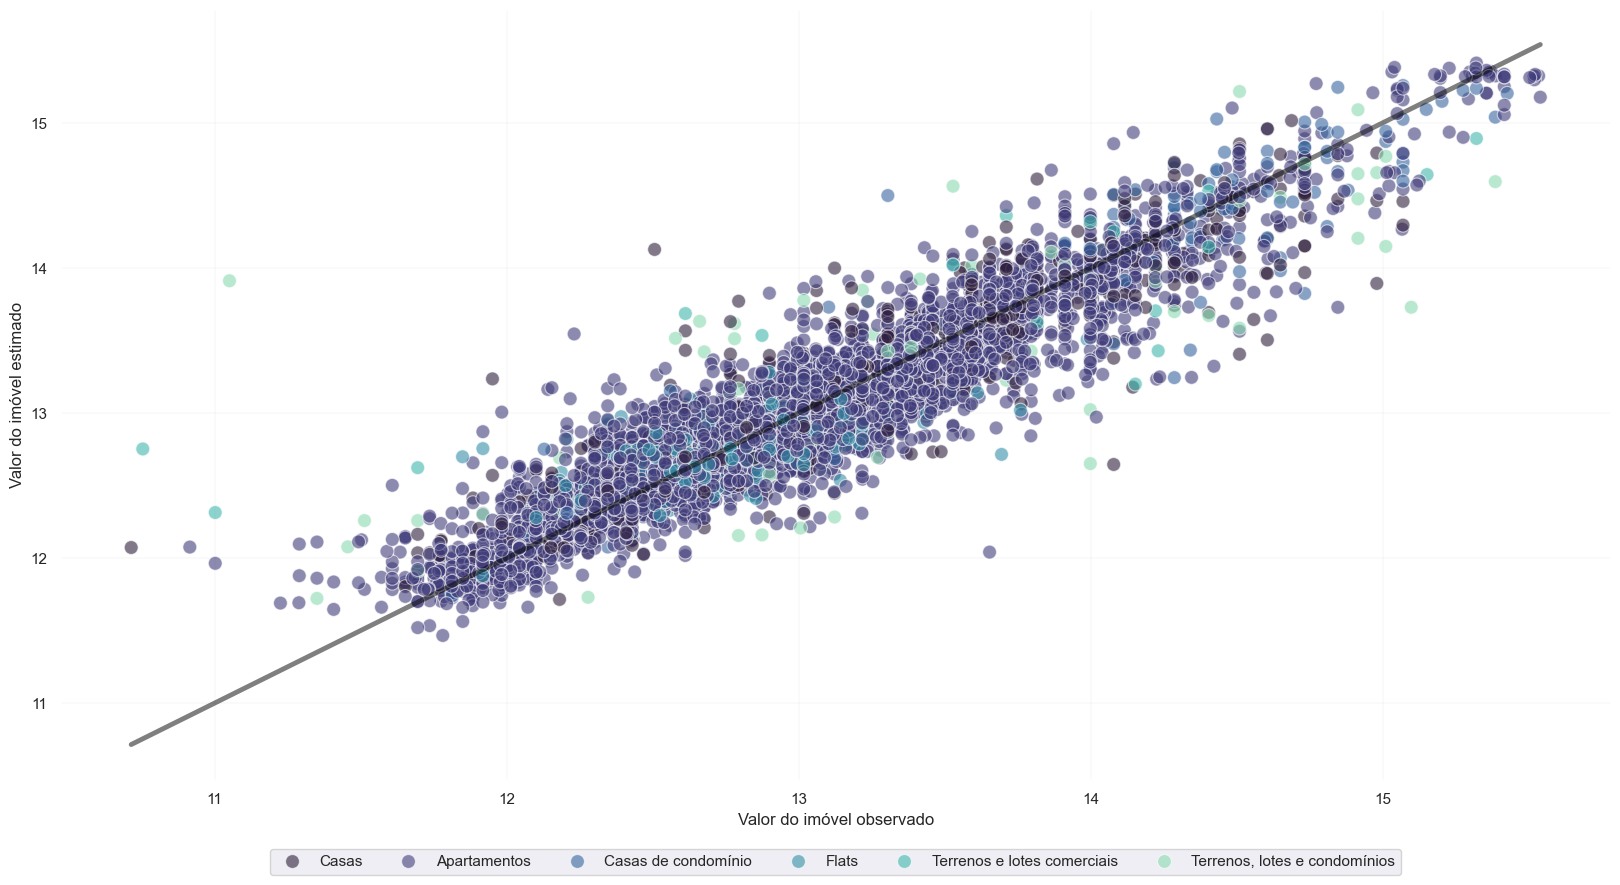

In [88]:
fig = plt.Figure(figsize=(20, 20))

plot = sns.scatterplot(
    data=test_df_clone,
    x='valor',
    y='preds_stacking',
    s=100,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(test_df_clone['valor'].min(), test_df_clone['preds_stacking'].min())
max_val = max(test_df_clone['valor'].max(), test_df_clone['preds_stacking'].max())
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

sns.set_theme(rc={'figure.figsize': (20, 10)})
plot.set_xlabel('Valor do imóvel observado')
plot.set_ylabel('Valor do imóvel estimado')

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=7)
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("../../tcc_escrita/includes/stacking_plot_predict.svg", dpi=600, bbox_inches='tight')
plt.show()

In [29]:
# from sklearn.inspection import partial_dependence

# X = test_df_novo.drop(columns=['valor'])
# features = X.columns.tolist()
# cat_features = [
#     'encoder__tipo_apartamentos', 'encoder__tipo_casas',
#     'encoder__tipo_casas_de_condominio', 'encoder__tipo_flats',
#     'encoder__tipo_terrenos_e_lotes_comerciais', 'encoder__tipo_terrenos_lotes_e_condominios',
#     'vertical_horizontal', 'varanda_gourmet', 'spa', 'sauna', 'salao_de_festa',
#     'portaria_24_horas', 'quadra_de_esporte', 'playground', 'piscina', 'espaco_gourmet',
#     'elevador', 'academia'
# ]
# num_features = np.array(features)[~X.columns.isin(cat_features)].tolist()

# pdp = partial_dependence(
#     stacking,
#     features=num_features,
#     # categorical_features=cat_features,
#     kind='both',
#     X=X)

In [28]:
# from sklearn.inspection import PartialDependenceDisplay

# X = test_df_novo.drop(columns=['valor'])
# features = X.columns.tolist()
# cat_features = [
#     'encoder__tipo_apartamentos', 'encoder__tipo_casas',
#     'encoder__tipo_casas_de_condominio', 'encoder__tipo_flats',
#     'encoder__tipo_terrenos_e_lotes_comerciais', 'encoder__tipo_terrenos_lotes_e_condominios',
#     'vertical_horizontal', 'varanda_gourmet', 'spa', 'sauna', 'salao_de_festa',
#     'portaria_24_horas', 'quadra_de_esporte', 'playground', 'piscina', 'espaco_gourmet',
#     'elevador', 'academia'
# ]
# num_features = np.array(features)[~X.columns.isin(cat_features)].tolist()

# ice_pdp = PartialDependenceDisplay\
#     .from_estimator(
#         stacking,
#         X,
#         num_features,
#         kind='both',
#         centered=True,
#         random_state=42
#     )

In [ ]:
import shap

X1000 = shap.utils.sample(train_df_novo.drop(columns="valor"), 1000)

explainer_stacking = shap.Explainer(stacking.predict, X1000)
shap_values_stacking = explainer_stacking(
    test_df_novo.drop(columns="valor")
)

PermutationExplainer explainer:   3%|▎         | 188/6357 [43:44<25:36:46, 14.95s/it]